In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.models import resnet18
from torchvision import transforms
from tqdm import tqdm
from torch import nn
from torch.utils.data import Dataset,TensorDataset,DataLoader,random_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from d2l import torch as d2l
import random
import os
import torch.nn.functional as F
from torch.autograd import grad
import torch.nn.init as init
d2l.use_svg_display()
%matplotlib inline
import math

['3C_battery-1', '3C_battery-10', '3C_battery-11', '3C_battery-12', '3C_battery-13', '3C_battery-14', '3C_battery-15', '3C_battery-2', '3C_battery-3', '3C_battery-4', '3C_battery-5', '3C_battery-6', '3C_battery-7', '3C_battery-8', '3C_battery-9']


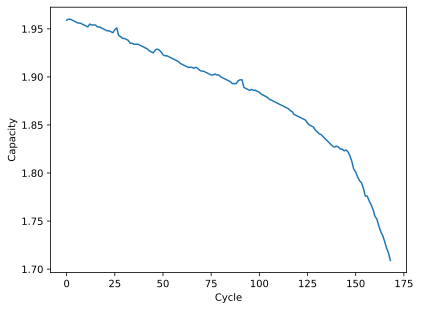

In [2]:
Batch_list=['Batch-1','Batch-2','Batch-3','Batch-4','Batch-5','Batch-6']
def choose_batch(Batch_name):
    Battery_list=[]
    dir='../source_data/XJTU_data/'+Batch_name
    for name in os.listdir(dir):
        Battery_list.append(name.strip('.mat'))
    source_data_path='../source_data/XJTU_data/'+Batch_name+'/'
    target_data_path='../data/XJTU_data/'+Batch_name+'/'+'all/'
    return Battery_list,source_data_path,target_data_path
Battery_list,source_data_path,target_data_path=choose_batch(Batch_list[1])
print(Battery_list)
def smooth_data(sequence, window_size):
    """数据平滑"""
    if window_size < 1:
        raise ValueError("窗口大小必须大于等于1")
    # 初始化平滑后的数据列表
    smoothed_sequence = []
    # 计算窗口内的平均值
    for i in range(len(sequence)):
        # 计算窗口的起始和结束索引
        start_index = max(0, i - window_size + 1)
        end_index = i + 1
        # 计算窗口内的数据平均值
        window_average = sum(sequence[start_index:end_index]) / (end_index - start_index)
        # 将平均值添加到平滑后的数据列表中
        smoothed_sequence.append(window_average)
    return smoothed_sequence
def add_row_index_to_array(arr):
    """
    在输入数组的每一行的第一个元素加上行号，并扩展数组维度。
    
    参数:
    arr (np.ndarray): 形状为 (n, 6) 的输入数组。
    
    返回:
    np.ndarray: 形状为 (n, 7) 的数组。
    """
    # 检查输入数组形状是否为 (n, 6)
    if arr.shape[1] != 10:
        raise ValueError("输入数组必须是形状为 (n, 10) 的数组。")

    # 创建一个新数组，其形状为 (n, 7)，初始化为输入数组
    new_arr = np.zeros((arr.shape[0], 11))
    new_arr[:, 1:] = arr  # 将输入数组的数据复制到新数组的后面六个列
    # 在新数组的每一行的第一个元素加上行号
    new_arr[:, 0] = np.arange(arr.shape[0])
    return new_arr
def make_sequences(text, window_size):
    """用容量作为文本序列text,window是窗口的大小"""
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+window_size]

        x.append(sequence)
        y.append(target)
    return np.array(x), np.array(y)
def drop_outlier(array,count,bins):
    """离群值提取--用3sigma方法"""
    index = []
    range_n = np.arange(1,count,bins)
    for i in range_n[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)
def clean_data(array_figs,array_labels):
    index_keep=drop_outlier(array_labels,len(array_labels),35)
    array_figs,array_labels=array_figs[index_keep],array_labels[index_keep]
    array_figs,array_labels=array_figs[drop_outlier(array_labels,len(array_labels),10)],array_labels[drop_outlier(array_labels,len(array_labels),10)]
    return array_figs,array_labels
data_root='../data/XJTU_data/Batch-3/all/'
for name in Battery_list[13:14]:
    path=data_root+name+'.npz'
    arrays=np.load(path)
    features,SOHs=clean_data(arrays['array1'],arrays['array2'])
    plt.plot(SOHs)
    # """抛弃异常值处理"""
    # index_keep=drop_outlier(SOHs,len(SOHs),35)
    # plt.plot(SOHs[index_keep][drop_outlier(SOHs[index_keep],len(SOHs[index_keep]),10)])
    # plt.plot(process_sequence(SOHs,1))
    plt.xlabel('Cycle')
    plt.ylabel('Capacity')

In [3]:
def setup_seed(seed):
    """set random seed"""
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return rmse
def get_data():
    """获取训练集，测试集，验证集"""
    train_list = Battery_list
    train_data=[]
    for b_n in train_list:
        path=data_root+b_n+'.npz'
        arrays = np.load(path)
        a,b=clean_data(arrays['array1'],arrays['array2'])
        a=add_row_index_to_array(a)
        train_data.append([a,b])
    train_features=np.concatenate((train_data[0][0],train_data[1][0],train_data[7][0],train_data[3][0],train_data[4][0],train_data[13][0]),axis=0)
    train_labls=np.concatenate((train_data[0][1],train_data[1][1],train_data[7][1],train_data[3][1],train_data[4][1],train_data[13][1]),axis=0)
    train_valid_features=torch.from_numpy(train_features).float()
    train_valid_labels=torch.from_numpy(train_labls).float()
    dataset=TensorDataset(train_valid_features,train_valid_labels)
    # 确定训练集和验证集的大小
    train_size = int(0.2 * len(dataset))  # 80%的训练集
    val_size = len(dataset) - train_size   # 剩余的20%作为验证集
    # 随机分割数据集
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    # 创建DataLoader
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_5_data,test_6_data,test_7_data,test_8_data=[train_data[10][0],train_data[10][1]],[train_data[11][0],train_data[11][1]],[train_data[12][0],train_data[12][1]],[train_data[13][0],train_data[13][1]]
    return train_loader, val_loader, test_5_data,test_6_data,test_7_data,test_8_data

a,b,c,d,e,e=get_data()
print(d,e)
for x,y in b:
    print(x.shape)

[array([[0.00000000e+00, 4.57089841e-01, 0.00000000e+00, ...,
        2.11701625e-01, 1.00000000e+00, 4.36999272e-04],
       [1.00000000e+00, 4.57089841e-01, 0.00000000e+00, ...,
        2.11701625e-01, 1.00000000e+00, 4.36999272e-04],
       [2.00000000e+00, 4.57089841e-01, 0.00000000e+00, ...,
        2.11701625e-01, 1.00000000e+00, 4.36999272e-04],
       ...,
       [1.95000000e+02, 1.54065561e-01, 7.65605670e-01, ...,
        6.56556134e-01, 2.74338320e-01, 8.20903132e-01],
       [1.96000000e+02, 1.46400509e-01, 7.75858676e-01, ...,
        6.46587063e-01, 2.64672037e-01, 8.27458121e-01],
       [1.97000000e+02, 1.29639536e-01, 7.87316905e-01, ...,
        6.18033249e-01, 2.54545455e-01, 8.35178441e-01]]), array([1.961, 1.962, 1.962, 1.962, 1.96 , 1.96 , 1.958, 1.958, 1.957,
       1.956, 1.955, 1.954, 1.957, 1.957, 1.956, 1.956, 1.956, 1.955,
       1.954, 1.954, 1.953, 1.952, 1.951, 1.95 , 1.95 , 1.95 , 1.954,
       1.955, 1.952, 1.95 , 1.948, 1.947, 1.939, 1.939, 1.938, 1.93

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim=11, output_dim=12, num_heads=4, head_dim=24, dropout=0):
        """用多头注意力进行解码"""
        """
        多头注意力模块。
        :param input_dim: 输入特征维度
        :param output_dim: 输出特征维度
        :param num_heads: 注意力头的数量
        :param head_dim: 每个注意力头的维度
        :param dropout: Dropout 概率
        """
        super(MultiHeadAttention, self).__init__()
        self.input_dim = input_dim-1
        self.output_dim = output_dim-1
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.dropout = dropout
        # 线性变换层，将输入映射到 Q, K, V
        self.query = nn.Linear(input_dim-1, num_heads * head_dim)
        self.key = nn.Linear(input_dim-1, num_heads * head_dim)
        self.value = nn.Linear(input_dim-1, num_heads * head_dim)
        # 输出线性层
        self.fc_out = nn.Linear(num_heads * head_dim, output_dim-1)
        # Dropout 层
        self.dropout_layer = nn.Dropout(dropout)
    def forward(self, x):
        """
        前向传播。
        :param x: 输入张量，形状为 (batch_size, input_dim)
        :return: 输出张量，形状为 (batch_size, output_dim)
        """
        batch_size = x.size(0)
        x_t=x[:,0].unsqueeze(1)
        x=x[:,1:]
        # 线性变换，得到 Q, K, V
        Q = self.query(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        K = self.key(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)    # (batch_size, num_heads, seq_len, head_dim)
        V = self.value(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        # 计算注意力分数
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))  # (batch_size, num_heads, seq_len, seq_len)
        attention_weights = F.softmax(scores, dim=-1)  # (batch_size, num_heads, seq_len, seq_len)
        attention_weights = self.dropout_layer(attention_weights)
        # 计算加权和
        attention_output = torch.matmul(attention_weights, V)  # (batch_size, num_heads, seq_len, head_dim)
        # 拼接多头输出
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)  # (batch_size, seq_len, num_heads * head_dim)
        # 通过线性层映射到输出维度
        output = self.fc_out(attention_output)  # (batch_size, seq_len, output_dim)
        output=torch.cat((x_t,output.squeeze(1)),dim=-1)
        return output  # (batch_size, output_dim)
"""--------------------------------------------------------多物理场混合专家模型-------------------------------------------------------"""
class MixtureOfExperts(nn.Module):
    def __init__(self, input_dim, num_experts, expert_hidden_dim):
        super(MixtureOfExperts, self).__init__()
        self.num_experts = num_experts
        # 专家网络
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, 2*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(2*expert_hidden_dim, 4*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(4*expert_hidden_dim, 8*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(8*expert_hidden_dim, 16*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(16*expert_hidden_dim, 32*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(32*expert_hidden_dim,64*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(64*expert_hidden_dim,32*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(32*expert_hidden_dim,16*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(16*expert_hidden_dim, 8*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(8*expert_hidden_dim, 4*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(4*expert_hidden_dim,expert_hidden_dim ),
            )
            for _ in range(num_experts)
        ])
        # 门控网络
        self.gating_network = nn.Linear(input_dim, num_experts)
        # 输出层
        self.output_layer = nn.Linear(expert_hidden_dim, 1)
    def initialize_weights(self):
        nn.init.xavier_uniform_(self.gating_network.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)
    def forward(self, x):
        # 计算所有专家的输出
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)
        #shape(batch_size,num_expert,expert_hidden_dim)
        # 计算门控网络的输出并应用softmax得到权重
        gate_works=torch.exp(self.gating_network(x)/10)
        gating_outputs = F.softmax(gate_works, dim=1)
        # 将门控网络的输出（权重）与专家网络的输出相乘并求和
        combined_output = torch.sum(expert_outputs * gating_outputs.unsqueeze(-1), dim=1)
        # 通过输出层得到最终输出
        final_output = self.output_layer(combined_output)
        return final_output,expert_outputs      #返回总输出和每个专家输出
    
class PINN_MOE(nn.Module):
    def __init__(self,input_dim=11, output_dim=12, num_heads=4, head_dim=24, dropout=0,expert_input_dim=12, num_experts=3,expert_hidden_dim=2):
        super(PINN_MOE, self).__init__()
        self.Decoupling=MultiHeadAttention(input_dim, output_dim, num_heads, head_dim, dropout)
        self.multi_physics=MixtureOfExperts(expert_input_dim, num_experts,expert_hidden_dim)
        self.physics=nn.Sequential(
            nn.Linear(6, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )
        # self.electricity=nn.Sequential(nn.Linear(expert_hidden_dim, 2*expert_hidden_dim),nn.ReLU(),nn.Linear(2*expert_hidden_dim,expert_hidden_dim),nn.ReLU(),nn.Linear(expert_hidden_dim,2))
        # self.heat=nn.Sequential(nn.Linear(expert_hidden_dim, 2*expert_hidden_dim),nn.ReLU(),nn.Linear(2*expert_hidden_dim,expert_hidden_dim),nn.ReLU(),nn.Linear(expert_hidden_dim,2))
        # self.mechine=nn.Sequential(nn.Linear(expert_hidden_dim, 2*expert_hidden_dim),nn.ReLU(),nn.Linear(2*expert_hidden_dim,expert_hidden_dim),nn.ReLU(),nn.Linear(expert_hidden_dim,2))
        self.parameter_heat=nn.Parameter(torch.tensor(1, dtype=torch.float32))
        self.parameter_electricity1=nn.Parameter(torch.tensor(1, dtype=torch.float32))
        self.parameter_electricity2=nn.Parameter(torch.tensor(1, dtype=torch.float32))
    def  initialize_weights(self):
        nn.init.xavier_uniform_(self.Decoupling.parameters)
        nn.init.xavier_uniform_(self.multi_physics.parameters)
        # nn.init.xavier_uniform_(self.heat.parameters)
        # nn.init.xavier_uniform_(self.mechine.parameters)
        # nn.init.xavier_uniform_(self.electricity.parameters)
        nn.init.xavier_uniform_(self.physics.parameters)
        nn.init.xavier_uniform_(self.parameter_heat)
        nn.init.xavier_uniform_(self.parameter_electricity1)
        nn.init.xavier_uniform_(self.parameter_electricity2)
    def forward(self, tx):
        tx.requires_grad_(True)
        # 解耦输入
        t_x = self.Decoupling(tx)
        t=t_x[:,0:1]
        x=t_x[:,1:]
        # 预测物理量
        s_pred,experts = self.multi_physics(torch.cat((t,x),dim=1))
        # 计算 s_pred 对 t 和 x 的偏导数
        """综合损失"""
        s_t = grad(s_pred.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        s_x = grad(s_pred.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        """热效应损失"""
        T_Q=experts[:,0:1,:].squeeze(1)
        # print(T_Q.shape)
        T=T_Q[:,0:1]
        Q=T_Q[:,1:2]
        T_t=grad(T.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        T_x=grad(T.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        T_laplace=grad(T_t.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        loss_heat=torch.mean((T_t - (self.parameter_heat) * T_laplace - Q) ** 2, dim=1).unsqueeze(1)
        """电化学效应损失"""
        phi_c=experts[:,1:2,:].squeeze(1)
        phi=phi_c[:,0:1]
        c=phi_c[:,1:2]
        phi_t=grad(phi.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        phi_x=grad(phi.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        c_x=grad(c.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        c_t=grad(c.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        phi_laplace=grad(phi_x.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        c_laplace=grad(c_x.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        loss_electricity=torch.mean((c_t -self.parameter_electricity1 * c_laplace -self.parameter_electricity2) ** 2,dim=1).unsqueeze(1)+torch.mean(phi_laplace** 2,dim=1).unsqueeze(1)
        """机械应力损失"""
        sigma_f=experts[:,2:3,:].squeeze(1)
        sigma=sigma_f[:,0:1]
        f=sigma_f[:,1:2]
        sigma_x=grad(sigma.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        sigma_laplace=grad(sigma_x.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        loss_mechine=torch.mean((sigma_laplace + f) ** 2,dim=1).unsqueeze(1)
        # 打印 s_t 和 s_x，确保它们不为 None
        # 计算物理约束 F
        F_input = torch.cat([phi,c,T,Q,sigma,f], dim=1)
        soh = self.physics(F_input)
        # 计算残差 f
        loss_all = 1*loss_electricity+1*loss_heat+1*loss_mechine
        return soh, loss_all,[phi,c,T,Q,sigma,f]

In [5]:
def train(lr=0.005,epochs=100, weight_decay=1e-5, seed=0, metric='rmse', device='cpu'):
    """function for train"""
    setup_seed(seed)
    print("training seed "+str(seed)+':\n')
    train_loader, val_loader, test_35_data, test_36_data, test_37_data,test_38_data=get_data()
    test_data=[test_35_data, test_36_data, test_37_data,test_38_data]
    model = PINN_MOE()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    len_dataloader = len(train_loader)
    test_results=[]
    lists=[]
    """早停止获取最佳模型"""
    val_mse=10
    train_loss=10
    for epoch in range(epochs):
        loss_epoch=0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            y_pred,f,_= model(X)
            f_target = torch.zeros_like(f)
            y_pred = y_pred.squeeze(1)
            loss = criterion(y_pred,y)+0.3*criterion(f,f_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss
        if (epoch+1)%5==0 and epoch!=0:
            print('Epoch:',epoch+1,'Train_RMSELoss:',loss_epoch/len_dataloader,'\n')
            train_loss=loss_epoch/len_dataloader
        if (epoch+1)%5==0 and epoch!=0:
            val_loss=0
            for val_x,val_y in val_loader:
                val_x,val_y=val_x.to(device),val_y.to(device)
                pre,_,_=model(val_x)
                val_loss+=criterion(pre.squeeze(1),val_y).detach()    
            print('Epoch:',epoch+1,'valid_RMSELoss:',val_loss/len(val_loader),'\n')
            val_mse=val_loss/len(val_loader)
                
        if (val_mse<0.00003 and train_loss<=5e-4) or (epoch+1)==epochs:
            model=model.cpu()
            for name in test_data:
                X=torch.from_numpy(name[0]).float()
                y=name[1]
                y_pred,_,list=model(X)
                for i in range(len(list)):
                    list[i]=list[i].detach().cpu().numpy()
                lists.append(list)
                y_pred= y_pred.squeeze(0).detach().numpy()
                test_results.append([y,y_pred])
            break
    return test_results,lists

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
test_results,lists=train(seed=0,device=device)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.2459, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.0439, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.0993, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.0024, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0586, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0011, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0367, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0010, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0245, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(0.0010, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(0.0169, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(0.0007, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0123, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 35 valid_RMSELoss: tensor(0.0

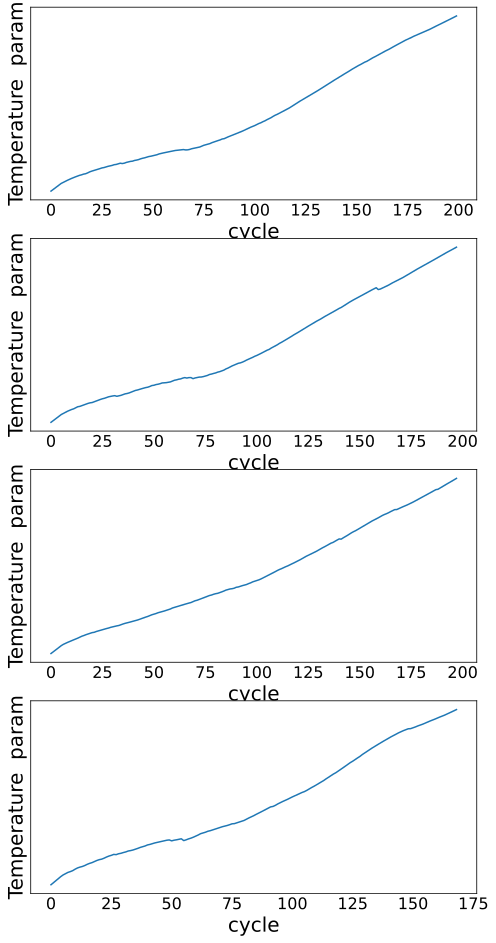

In [7]:
plt.rcParams['xtick.labelsize'] = 16
fig, axes = plt.subplots(4, 1, figsize=(8, 16))
for i in range(4):
    # axes[i].plot(test_results[i][0][:800])
    # axes[i].plot(test_results[i][1][:800])
    axes[i].plot(lists[i][5])
    #axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].tick_params(axis='both', which='both', length=0)
    axes[i].set_xlabel('cycle',fontsize=20)
    axes[i].set_ylabel('Temperature  param',fontsize=20)

In [8]:
path='D:/Pywork/CNN_ATTENTION_PINN/new/results/xjtu3/'
for i in range(4):
    e=lists[i][2]
    s=lists[i][5]
    np.savez(path+f'result{i}.npz',array1=e,array2=s)